In [1]:
! pip install -Uqq duckduckgo_search

In [2]:
from fastcore.all import *
from duckduckgo_search import ddg_images
def search_images(term, max_images=200):    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls=search_images('dog photos', max_images=1)
urls[0]

'https://www.insidedogsworld.com/wp-content/uploads/2016/03/Dog-Pictures.jpg'

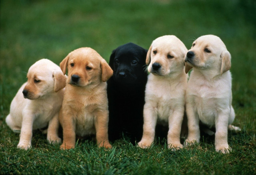

In [4]:
from fastdownload import download_url
dest='dog.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im=Image.open(dest)
im.to_thumb(256,256)

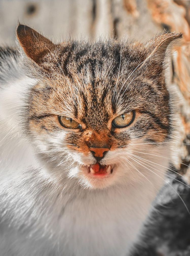

In [5]:
download_url(search_images('cat photos', max_images=1)[0], 'cat.jpg', show_progress=False)
Image.open('cat.jpg').to_thumb(256,256)

In [6]:
searches = 'cat','dog'
path = Path('dog_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    results=search_images(f'{o} photo')
    download_images(dest, urls=results[:200])
    resize_images(path/o, max_size=400, dest=path/o)
     

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
failed=verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

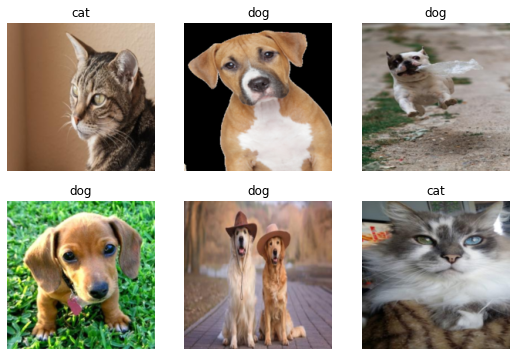

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.331139,0.008315,0.001912,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.018846,0.017533,0.003824,00:12
1,0.017263,0.000953,0.000000,00:12
2,0.010281,0.000291,0.000000,00:12


In [10]:
is_dog,_,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a: {is_dog}.")
print(f"Probability it's a dog: {probs[1]:.4f}")

This is a: dog.
Probability it's a dog: 1.0000
